In [19]:
# ================================
# System Utilities
# ================================
import os
import shutil
import platform
import re
import time
import importlib  # Needed for reloading the module


import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle


# ================================
# Data Handling and Manipulation
# ================================
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler
import pickle

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


# ================================
# Image Processing
# ================================
from PIL import Image, ImageEnhance, ImageOps
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Machine Learning and Deep Learning
# ================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ================================
# Utilities
# ================================
from IPython.display import clear_output
import random
from tqdm import tqdm

# ================================
# PyTorch: Check for GPU (MPS) Availability
# ================================
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available and will be used.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device is available and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU device available, using CPU instead.")

print(f"Using device: {device}")

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

from auth_preprocessing_util import (
    preprocess_data_generalization_auth,
    Evaluation_Dataset_Memory,
    LSTMAutoencoder,
    load_preprocessing_results,
    process_features_silent_auth,
    score_kmeans_similarity_chunks,
    score_similarity_to_reference
)

MPS device is available and will be used.
Using device: mps


In [20]:
##
## Load LSTM
##
grid_id = "5"
logdir = 'mila'

result_file = f'args_{grid_id}.csv'
checkpoint_path = os.path.join(logdir, f'checkpoint_{grid_id}.pth')

if not os.path.exists(os.path.join(logdir, result_file)) or not os.path.exists(checkpoint_path):
    print(f"Missing files for grid ID: {grid_id}")
else:
    print(f"Loading args from: {result_file}")
    print(f"Loading checkpoint from: {checkpoint_path}")

args_df = pd.read_csv(os.path.join(logdir, result_file))

class Args:
    pass
args = Args()
args.data_path = 'XYZ'
args.chunk_size = int(args_df['chunk_size'][0])
args.ignore_qid = True
args.chunk_slider_interval = 10
args.model = args_df['model'][0]
args.depth = str(args_df['depth'][0])
args.latent_dim = int(args_df['latent_dim'][0])
args.weights = checkpoint_path
args.grid_id = grid_id
args.batch_size = int(args_df['batch_size'][0])
args.input_dim = int(args_df['input_dim'][0])
args.hidden_dim = int(args_df['hidden_dim'][0])
args.patch_size = int(args_df['patch_size'][0])
args.num_head = int(args_df['num_head'][0])

# ------------------------------
# LOAD MODEL
# ------------------------------
model = LSTMAutoencoder(args.input_dim, args.latent_dim, args.hidden_dim).to(device)
checkpoint = torch.load(args.weights, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

## 
## Load movement space
##
X_processed_test, y_avg_test, unique_ids_test, kmeans_model_test = load_preprocessing_results('./mila', dataset_type="test", grid_id=grid_id, add_mean=0, add_features=0, num_pcs=0, num_clusters=500)

Loading args from: args_5.csv
Loading checkpoint from: mila/checkpoint_5.pth
Loaded: ./mila/grid_5_mean_0_features_0_pcs_0_clusters_500_test.pkl


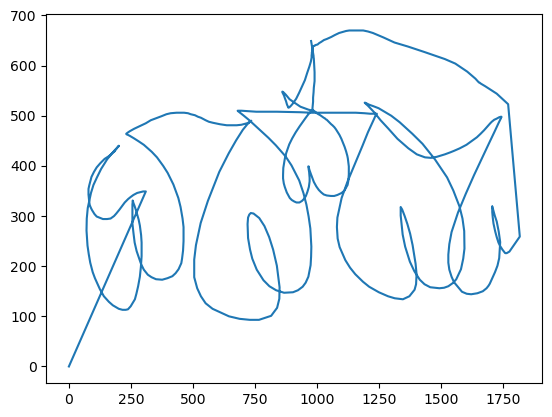

In [ ]:
##
## Load cursor tracking
##
file_path = "/Users/veithweilnhammer/Downloads/cursor_data_1746724677556.csv"
user_id = 123
session_id = 456
input_data = pd.read_csv(file_path)
plt.plot(input_data.x, input_data.y)

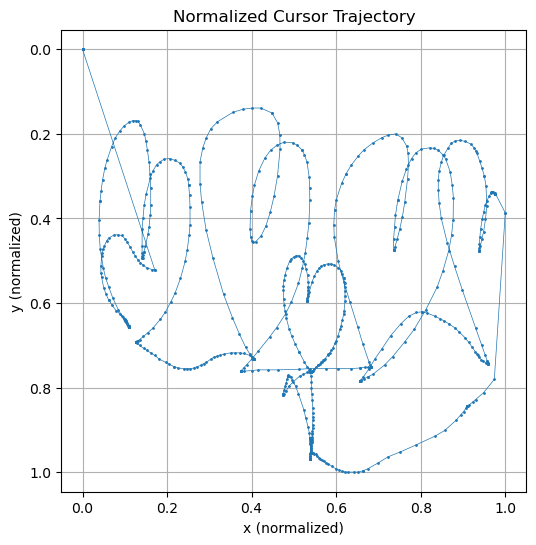

In [37]:
##
## GET score
##
preprocessed_data = preprocess_data_generalization_auth(input_data, user_id, session_id, drop_short_sessions=True)

data_array = preprocessed_data[0]['data']

plt.figure(figsize=(6, 6))
plt.plot(data_array[:, 0], data_array[:, 1], marker='o', markersize=1, linewidth=0.5)
plt.xlabel("x (normalized)")
plt.ylabel("y (normalized)")
plt.title("Normalized Cursor Trajectory")
plt.gca().invert_yaxis()  # Optional: comment this out if you want to keep browser-style coordinates
plt.grid(True)
plt.axis("equal")
plt.show()

In [ ]:

dataset = Evaluation_Dataset_Memory(
    preprocessed_data,
    chunk_size=args.chunk_size,
    ignore_qid=args.ignore_qid,
    chunk_slider_interval=args.chunk_slider_interval
)
data_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

feature_array = []
time_array = []
session_array = []
id_array = []
with torch.no_grad():
    for mouse_data, qid, pid in data_loader:
        mouse_data = mouse_data.to(device)
        feat = model.get_feat(mouse_data).cpu().numpy()
        for i in range(feat.shape[0]):
            feature_array.append(feat[i])

            chunk_start_index = i * args.chunk_slider_interval
            try:
                time_value = preprocessed_data[0]['pos_response'][chunk_start_index]
            except IndexError:
                time_value = np.nan

            time_array.append(time_value)
            session_array.append(session_id)
            id_array.append(user_id)

X, time, id, _ = process_features_silent_auth(
    np.array(feature_array, dtype=np.float64),
    np.array(time_array, dtype=np.float64),
    np.array(id_array).astype(int).flatten(),
    add_mean=0,
    add_features=0,
    num_pcs=0,
    num_clusters=500,
    n_windows=0,
    kmeans_model=kmeans_model_test
)

movement_score = score_kmeans_similarity_chunks(feature_array, kmeans_model_test)
mila_score = score_similarity_to_reference(X, X_processed_test)
human_score = np.mean([movement_score, mila_score])
print(f'scores: embedding = {movement_score }, mila = {mila_score}, human = {human_score}')

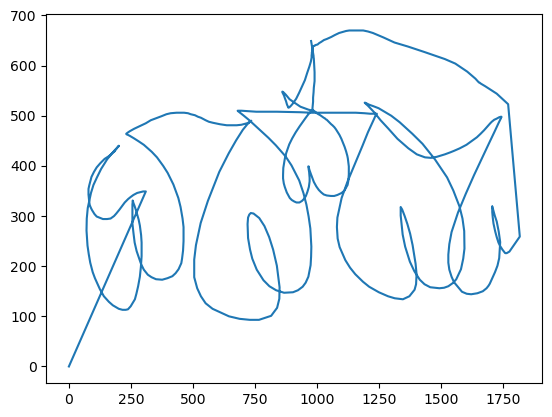

In [32]:
test_data = pd.read_csv('/Users/veithweilnhammer/Downloads/cursor_data_1746724333489.csv')
plt.plot(test_data.x, test_data.y)